---

### Imports

In [10]:
"""
Setup notebook
"""

# Python >= 3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tfx==0.21.2
    print("You can safely ignore the package incompatibility errors.")
except Exception:
    pass

# TensorFlow >= 2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import numpy as np
import soundfile as sf
import os
import glob
import tqdm
import json
import librosa
from librosa import display
from pathlib import Path
import IPython.display as pd
import matplotlib.pyplot as plt
#import sounddevice as sd

---

## 1. Load and explore the dataset

In [4]:
dir = 'Trial_Data'
sig_Conv = '/Convolved_Sig'
sig_Clean = '/GuitSigClean_Monophon'
impRes = '/IR_Trial'
# Inhalt beider Unterverzeichnisse anzeigen mit zwei Sternen
pathSigConv = dir + sig_Conv + '/*/*.wav'
pathSigClean = dir + sig_Clean + '/*.wav'
pathImpRes = dir + impRes + '/*/*.wav'
print(pathSigConv)
print(pathImpRes)

Trial_Data/Convolved_Sig/*/*.wav
Trial_Data/IR_Trial/*/*.wav


In [5]:
# see the classes 
path_test = dir + impRes + '/*'
#folders = glob.glob('_data/TinyUrbanSound8k/*/*/')
folders = glob.glob(path_test)
folders

['Trial_Data/IR_Trial\\IR_1.wav',
 'Trial_Data/IR_Trial\\IR_10.wav',
 'Trial_Data/IR_Trial\\IR_2.wav',
 'Trial_Data/IR_Trial\\IR_3.wav',
 'Trial_Data/IR_Trial\\IR_4.wav',
 'Trial_Data/IR_Trial\\IR_5.wav',
 'Trial_Data/IR_Trial\\IR_6.wav',
 'Trial_Data/IR_Trial\\IR_7.wav',
 'Trial_Data/IR_Trial\\IR_8.wav',
 'Trial_Data/IR_Trial\\IR_9.wav']

Show unique labels:

In [60]:
classes = sorted(set([Path(f).parts[-1] for f in folders]))

for i,iter in enumerate(classes):
    tmp = str.split(iter, '.')
    classes[i] = tmp[0]
classes

['IR_1',
 'IR_10',
 'IR_2',
 'IR_3',
 'IR_4',
 'IR_5',
 'IR_6',
 'IR_7',
 'IR_8',
 'IR_9']

Create test and training data

In [7]:
# Basti 11.01.2022:
# 
# Hier müssen noch die Daten randomisiert werden, bzw. besser passiert das direkt in der Generierung der Daten
# so löpt dat noch nicht



Like always, let's have a look at some random samples:

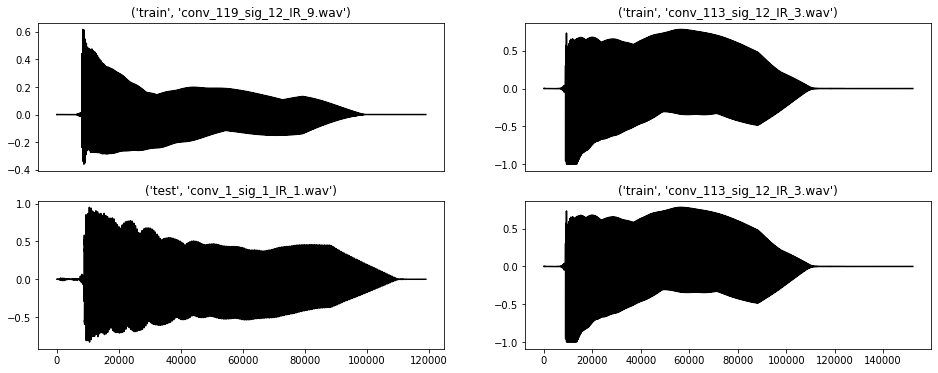

In [8]:
# get all wav files

fps = glob.glob( pathSigConv , recursive=True)
fps_ImpRes = glob.glob( pathImpRes , recursive=True)

fps_random = []
np.random.seed(9)

# setup subplot 
nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))

# plot some audio waveforms
for r in range(nrows):
    for c in range(ncols):
        fp_random = fps[np.random.randint(len(fps))]
        audio, sr = librosa.core.load(fp_random, sr=None)
        ax[r][c].plot(audio, c='k')
        # ax[r][c].axis('off')
        ax[r][c].set_title(Path(fp_random).parts[-2:])
        if r == 0:
            ax[r][c].set_xticks([])
        # save random audio filepaths
        fps_random.append(fp_random)

In [ ]:
# pad all files to the same length

In [11]:
# listen to the audio samples
for fp in fps_random:
    print(fp)
    pd.display(pd.Audio(fp))

Trial_Data/Convolved_Sig\train\conv_119_sig_12_IR_9.wav


Trial_Data/Convolved_Sig\train\conv_113_sig_12_IR_3.wav


Trial_Data/Convolved_Sig\test\conv_1_sig_1_IR_1.wav


Trial_Data/Convolved_Sig\train\conv_113_sig_12_IR_3.wav


### 2.4. Calculating spectrograms

Several python libraries offer **STFT and Melspectrogram functions**, for example librosa. The mel spectrogram reduces the feature dimensionality (size of the spectrogram) by a factor defined by the ratio of fft bins to mel bins, and at the same time preserving most of the spectrogram information.  

C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


Melspec shape: (64, 595)
Stft shape: (1025, 595)
Total data points in mel-spectrogram: 38080
Total data points in stft-spectrogram: 609875
-> Data Reduction by factor: 16.015625



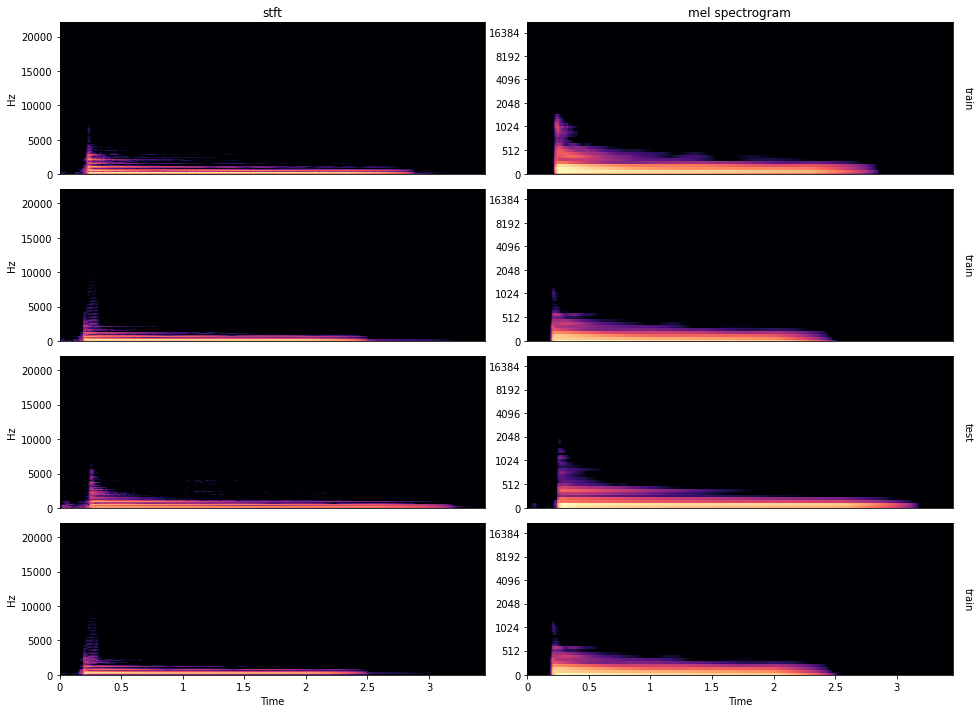

In [12]:
# setup subplot 
nrows, ncols = 4, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))

# plot some audio waveforms
for i, fp_random in enumerate(fps_random):
    audio, sr = librosa.core.load(fp_random, sr=None)

    # calculate stft
    stft = librosa.stft(audio, n_fft=2048, hop_length=256, win_length=2048)
    
    # calculate melspec
    melspec = librosa.feature.melspectrogram(audio, n_fft=2048, hop_length=256, win_length=2048, n_mels=64, fmax=int(sr/2))
    melspec = librosa.amplitude_to_db(melspec, ref=np.max)

    # calculate magnitude and scale to dB
    magspec = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    # plot with librosa
    librosa.display.specshow(magspec, x_axis='time', y_axis='linear', sr=sr, hop_length=256, ax=ax[i][0])
    librosa.display.specshow(melspec, x_axis='time', y_axis='mel', sr=sr, hop_length=256, ax=ax[i][1])
    
    # adjustments
    # ax[i][1].set_yticks([])
    ax[i][1].set_ylabel(Path(fp_random).parts[-2], rotation=270, labelpad=20)
    ax[i][1].yaxis.set_label_position("right")
    
    # settings for all axises but bottom ones
    if not i == len(fps_random) - 1:
        ax[i][0].set_xticks([])
        ax[i][1].set_xticks([])
        ax[i][0].set_xlabel('')
        ax[i][1].set_xlabel('')
    
    # settings for upper axises
    if i == 0:
        ax[i][0].set_title('stft')
        ax[i][1].set_title('mel spectrogram')   

# adjust whitespace in between subplots        
plt.subplots_adjust(hspace=0.1, wspace=0.1)

print('Melspec shape: %s' % (str(melspec.shape)))
print('Stft shape: %s' % (str(stft.shape)))
print(f'Total data points in mel-spectrogram: {melspec.shape[0]*melspec.shape[1]}')
print(f'Total data points in stft-spectrogram: {stft.shape[0]*stft.shape[1]}')
print(f'-> Data Reduction by factor: {(stft.shape[0]*stft.shape[1]) / (melspec.shape[0]*melspec.shape[1])}')
print()

---

## 3. The Data API
Central to the Data API is the *dataset*, the object which will contain all the training examples. As a starting point we will build a synthetic dataset of numbers to get familiar with the functions of the Data API.

In [16]:
# data source, a vector [0,...,10]
X = tf.range(11)
# dataset from tensor slices -> 11 elements in the dataset
dataset = tf.data.Dataset.from_tensor_slices(X)

# simply iterate over the dataset
for elem in dataset:
    print(elem)


tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)


We always recommend to check the documentation when looking into new frameworks -> https://www.tensorflow.org/api_docs/python/tf/data/Dataset
However, this way we can also get a quick look at the available dataset functions.

In [61]:
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("- {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))


TypeError: 'str' object is not callable

Moving foreward we will have a closer look at the following functions: `batch()`, `map()`, `prefetch()`, `shuffle()`.

### 3.1. Batch
Batching is the process of grouping a number of examples into a batch. This function is used everywhere since batches of data allow for a more stable gradient decent and efficient hardware usage. 

In [18]:
# same dataset as before
dataset = tf.data.Dataset.range(11)
# batches of two if possible
dataset = dataset.batch(2)
for elem in dataset:
    print(elem)

tf.Tensor([0 1], shape=(2,), dtype=int64)
tf.Tensor([2 3], shape=(2,), dtype=int64)
tf.Tensor([4 5], shape=(2,), dtype=int64)
tf.Tensor([6 7], shape=(2,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)
tf.Tensor([10], shape=(1,), dtype=int64)


### 3.2. Map
`map()` allows you to apply a function to each element of your dataset. This function will be used to apply any preprocessing 
to your data. By setting the num_parallel_calls argument you control how many parallel processes 
compute your preprocessing pipeline. However, there is one downside to this convenience, the function 
passed to `map()` has to convertible to a TF Function, as we will see later.

In [19]:
dataset = tf.data.Dataset.range(11)
# calculate the power of 2 across all elements of the dataset
dataset = dataset.map(lambda x: x ** 2, num_parallel_calls=2)
for elem in dataset:
    print(elem)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(16, shape=(), dtype=int64)
tf.Tensor(25, shape=(), dtype=int64)
tf.Tensor(36, shape=(), dtype=int64)
tf.Tensor(49, shape=(), dtype=int64)
tf.Tensor(64, shape=(), dtype=int64)
tf.Tensor(81, shape=(), dtype=int64)
tf.Tensor(100, shape=(), dtype=int64)


### 3.3. Prefetch
The `prefetch()` function will try to prepare a batch of training examples ahead of the moment the training pipeline will need them. For example, `prefetch(2)` will always try to have two batches ready before the training step is done. This allows you to run the preprocessing step and training step of your pipeline in parallel.

### 3.4. Shuffle
It is a best practice to shuffle your data before feeding it into your training step. This ensures that your training examples are independant from each other and different patterns are evenly distributed across your dataset. When considering to shuffle your dataset the order you call your functions in, plays a vital role. For example, if you first batch your dataset and then shuffel you will only shuffle the order of your batches not the composition of each batch (try it!). In most cases, if batches repeat in their composition your model will have a hard time learning generalized patterns from the data. 

For more details on the Data API visit this tutorial by TensorFlow: https://www.tensorflow.org/guide/data_performance

In [20]:
dataset = tf.data.Dataset.range(11)
# always think about the buffer size! How many elements are in your dataset? Is it somehow ordered? 
# If possible buffer the entire dataset -> highest "randomness"
dataset = dataset.shuffle(buffer_size=2)
for elem in dataset:
    print(elem)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


---

## 4. Online Preprocessing


For the spectrograms calculation we need to define some parameters. Since we need those several times in the follwing functions and script, a best practice is to **collect all these parameters in a dictionary** and save it besides the features, so we have a reference when we reload the features for training.

In [62]:
# best-practice: write down your preprocessing config in a dictonary
config = {'sr': 16000, 
          'audio_length': 1,
          'mono': True,
          'n_mels': 64,
          'n_fft': 2048,
          'hop_length': 256,
          'win_length': 2048,
          'window': 'hann',
          'center': True,
          'pad_mode': 'reflect',
          'power': 2.0,
          'classes': classes
         }

# save number of frames from length in samples divided by fft hop length
config['n_frames'] = int(config['sr']*config['audio_length']/config['hop_length']) + 1

# save input shape for model
config['input_shape'] = (config['n_mels'], config['n_frames'], 1)

# save config 
with open('Trial_Data/Convolved_Sig/Convolved_Sig_config.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)

# pretty print json
print(json.dumps(config, indent=4))

{
    "sr": 16000,
    "audio_length": 1,
    "mono": true,
    "n_mels": 64,
    "n_fft": 2048,
    "hop_length": 256,
    "win_length": 2048,
    "window": "hann",
    "center": true,
    "pad_mode": "reflect",
    "power": 2.0,
    "classes": [
        "IR_1",
        "IR_10",
        "IR_2",
        "IR_3",
        "IR_4",
        "IR_5",
        "IR_6",
        "IR_7",
        "IR_8",
        "IR_9"
    ],
    "n_frames": 63,
    "input_shape": [
        64,
        63,
        1
    ]
}


### 4.1. Computational Graph Compliance

Getting *exotic* preprocessing into TensorFlow can be difficult, since we have to provide a computational graph compliant implementation. In the following example we make use of `tf.py_function()` to implement the librosa based preprocessing in a TensorFlow compliant way. This function allows to run arbitrary python code inside the computation graph. However, this step can pose challenges and there are even functions which can't be called at all inside a `tf.py_function()`. 
As you will see we have to calculate the mel-spectrogram in a more lengthy way, this is due to an kernel death which occurs when using `librosa.feature.melspectrogram()` directly. Why you ask? - No idea, it may even work on your system or with a different version of either librosa or TensorFlow. On the bright side, this implementation is more efficient since the mel-filter has to be calculated only once!

In [63]:
# generate mel-filter matrix
mel_filter = librosa.filters.mel(config['sr'], 
                                 config['n_fft'], 
                                 n_mels=config['n_mels'], 
                                 fmin=0.0, 
                                 fmax=None, 
                                 htk=False, 
                                 norm='slaney', 
                                 dtype=np.float32)


def folder_name_to_one_hot(file_path):
    
    # for example: _data/TinyUrbanSound8k/train/siren/157648-8-0-0_00.wav
    label = Path(file_path).parts[-2]
    label_idx = classes.index(label)
    
    # get one hot encoded array
    one_hot = tf.one_hot(label_idx, len(config['classes']), on_value=None, off_value=None, 
                         axis=None, dtype=tf.uint8, name=None)
    return one_hot


def load_and_preprocess_data(file_path):
    # path string is saved as byte array in tf.data.dataset -> convert back to str
    if type(file_path) is not str:
        file_path = file_path.numpy()
        file_path = file_path.decode('utf-8')
    
    
    # load audio data 
    y, _ = librosa.core.load(file_path, sr=config['sr'], mono=config['mono'], offset=0.0, duration=None, 
                             dtype=np.float32, res_type='kaiser_best')

    # calculate stft from audio data
    stft = librosa.core.stft(y, n_fft=config['n_fft'], hop_length=config['hop_length'], 
                             win_length=config['win_length'], window=config['window'], 
                             center=config['center'], dtype=np.complex64, pad_mode=config['pad_mode'])

    # filter stft with mel-filter
    mel_spec = mel_filter.dot(np.abs(stft).astype(np.float32) ** config['power'])
    
    # add channel dimension for conv layer  compatibility
    mel_spec = np.expand_dims(mel_spec, axis=-1)
    
    # get ground truth from file_path string
    one_hot = folder_name_to_one_hot(file_path)
    
    return mel_spec, one_hot


# there is a TF bug where we get an error if the size of the tensor from a py.function is not set manualy
# when called from a map()-function.
def preprocessing_wrapper(file_path):
    mel_spec, one_hot = tf.py_function(load_and_preprocess_data, [file_path], [tf.float32, tf.uint8])
    
    mel_spec.set_shape([config['n_mels'], config['n_frames'], 1])
    one_hot.set_shape([len(config['classes'])])
    return mel_spec, one_hot

Loading the train and test datasets:

### 4.2. Create dataset directly from wav files

In [72]:
# autotune computation
AUTOTUNE = tf.data.experimental.AUTOTUNE

# folder with the training data
train_files = './Trial_Data/Convolved_Sig/train/*/*.wav'

# define a dataset of file paths
train_dataset = tf.data.Dataset.list_files(train_files)
# run the preprocessing via map
train_dataset = train_dataset.map(preprocessing_wrapper, num_parallel_calls=AUTOTUNE)
# shuffle the data
train_dataset = train_dataset.shuffle(buffer_size=4000)
# batch examples
train_dataset = train_dataset.batch(64)

# The issue here is that we want to batch the data
# Datensatz nochmal auf gleiche Größe bringen?!
dataset = train_dataset.unbatch()
dataset = train_dataset.batch(64)

# prefetch
train_dataset = train_dataset.prefetch(AUTOTUNE)


# folder with the evaluation data
test_files = './Trial_Data/Convolved_Sig/test/*.wav'

# define a dataset of file paths
test_dataset = tf.data.Dataset.list_files(test_files)
# run the preprocessing via map
test_dataset = test_dataset.map(preprocessing_wrapper, num_parallel_calls=AUTOTUNE)
# batch examples
test_dataset = test_dataset.batch(64)
# The issue here is that we want to batch the data
# Datensatz nochmal auf gleiche Größe bringen?!
dataset = test_dataset.unbatch()
dataset = test_dataset.batch(64)

# prefetch
test_dataset = test_dataset.prefetch(AUTOTUNE)

In [73]:
train_dataset

<PrefetchDataset shapes: ((None, 64, 63, 1), (None, 10)), types: (tf.float32, tf.uint8)>

### 4.3. Train model with tf.dataset

In [69]:
# create model architecture
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=config['input_shape']))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.GaussianDropout(0.25))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.GaussianDropout(0.25))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(tf.keras.layers.GlobalMaxPool2D())
model.add(tf.keras.layers.Dense(len(config['classes']), activation="sigmoid"))
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_5 (Batc  (None, 64, 63, 1)        4         
 hNormalization)                                                 
                                                                 
 conv2d_15 (Conv2D)          (None, 62, 61, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 30, 32)       0         
 g2D)                                                            
                                                                 
 gaussian_dropout_10 (Gaussi  (None, 31, 30, 32)       0         
 anDropout)                                                      
                                                                 
 conv2d_16 (Conv2D)          (None, 29, 28, 64)        18496     
                                                      

In [74]:
# compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# fit model
model.fit(train_dataset, epochs=4)
model.evaluate(test_dataset)

Epoch 1/4


InvalidArgumentError:  Cannot batch tensors with different shapes in component 0. First element had shape [64,165,1] and element 1 had shape [64,188,1].
	 [[node IteratorGetNext
 (defined at C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\keras\engine\training.py:866)
]] [Op:__inference_train_function_6345]

Errors may have originated from an input operation.
Input Source operations connected to node IteratorGetNext:
In[0] iterator (defined at C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\keras\engine\training.py:1216)

Operation defined at: (most recent call last)
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\asyncio\base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\asyncio\base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\asyncio\events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\SEBAST~1.BER\AppData\Local\Temp/ipykernel_19932/3775057991.py", line 7, in <module>
>>>     model.fit(train_dataset, epochs=4)
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\keras\engine\training.py", line 866, in step_function
>>>     data = next(iterator)
>>> 

---

## 5. Offline Preprocessing
New features make saving a dataset as easy as adding one line of code. This feature is available in TF2.3 and above.

In [29]:
# autotune computation
AUTOTUNE = tf.data.experimental.AUTOTUNE

# folder with the training data
train_files = './Trial_Data/Convolved_Sig/train/*.wav'
# define a dataset of file paths
train_dataset = tf.data.Dataset.list_files(train_files)
# run the preprocessing via map
train_dataset = train_dataset.map(preprocessing_wrapper, num_parallel_calls=AUTOTUNE)
# save dataset to disk
!rm -rf ./Trial_Data/Convolved_Sig/train
tf.data.experimental.save(dataset=train_dataset, path='./Trial_Data/train', compression='GZIP')
# show tensor types and shapes in dataset (we need this to load the dataset later)
print(train_dataset.element_spec)

# folder with the evaluation data
test_files = './Trial_Data/Convolved_Sig/test/*.wav'

# define a dataset of file paths
test_dataset = tf.data.Dataset.list_files(test_files)
# run the preprocessing via map
test_dataset = test_dataset.map(preprocessing_wrapper, num_parallel_calls=AUTOTUNE)
# save dataset to disk
!rm -rf ./Trial_Data/Convolved_Sig/test
tf.data.experimental.save(dataset=test_dataset, path=f'./Trial_Data/test', compression='GZIP')

Der Befehl "rm" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


InvalidArgumentError: ValueError: 'train' is not in list
Traceback (most recent call last):

  File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\tensorflow\python\ops\script_ops.py", line 273, in __call__
    return func(device, token, args)

  File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\tensorflow\python\ops\script_ops.py", line 151, in __call__
    outputs = self._call(device, args)

  File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\tensorflow\python\ops\script_ops.py", line 158, in _call
    ret = self._func(*args)

  File "C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\SEBAST~1.BER\AppData\Local\Temp/ipykernel_19932/629096954.py", line 47, in load_and_preprocess_data
    one_hot = folder_name_to_one_hot(file_path)

  File "C:\Users\SEBAST~1.BER\AppData\Local\Temp/ipykernel_19932/629096954.py", line 16, in folder_name_to_one_hot
    label_idx = classes.index(label)

ValueError: 'train' is not in list


	 [[{{node EagerPyFunc}}]] [Op:SaveDataset]

In [ ]:
train_dataset

You can print out the structure of your dataset with `train_dataset.element_spec`, this is the only information you need to load the dataset from disk later on.

In [28]:
# load a dataset from disk

train_dataset = tf.data.experimental.load(f'./Trial_Data/Convolved_Sig/train', 
                                    (tf.TensorSpec(shape=(config['n_mels'], config['n_frames'], 1), dtype=tf.float32, name=None), 
                                     tf.TensorSpec(shape=(len(config['classes']),), dtype=tf.uint8, name=None)), 
                                    compression='GZIP')
# keep dataset in memory
train_dataset = train_dataset.cache()
# shuffle the data
train_dataset = train_dataset.shuffle(buffer_size=4000)
# batch examples
train_dataset = train_dataset.batch(64)
# prefetch
train_dataset = train_dataset.prefetch(AUTOTUNE)

test_dataset = tf.data.experimental.load(f'./Trial_Data/Convolved_Sig/test', 
                                    (tf.TensorSpec(shape=(config['n_mels'], config['n_frames'], 1), dtype=tf.float32, name=None), 
                                     tf.TensorSpec(shape=(len(config['classes']),), dtype=tf.uint8, name=None)), 
                                    compression='GZIP')
# keep dataset in memory
test_dataset = test_dataset.cache()
# batch examples
test_dataset = test_dataset.batch(64)
# prefetch
test_dataset = test_dataset.prefetch(AUTOTUNE)

NotFoundError: Could not find metadata file. [Op:LoadDataset]

Train the model from the saved dataset:

In [ ]:
# create model architecture
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=config['input_shape']))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.GaussianDropout(0.25))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.GaussianDropout(0.25))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(tf.keras.layers.GlobalMaxPool2D())
model.add(tf.keras.layers.Dense(len(config['classes']), activation="sigmoid"))

# compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# fit model
model.fit(train_dataset, epochs=10)
model.evaluate(test_dataset)

---

# END

---

### Further reading and resources:

#### UrbanSound8k dataset:  
https://urbansounddataset.weebly.com/urbansound8k.html


#### Audio representations and processing:  
Old-school explanation of Fourier Transform from Alan Oppenheim: \
https://www.youtube.com/watch?v=dHveJh0UbY8

Newer explanation of Fourier Transform from 3Blue1Brown: \
https://www.youtube.com/watch?v=spUNpyF58BY

Python Notebooks for Fundamentals of Music Processing: \
https://www.audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html

Collection of instructional materials for music information retrieval: \
https://musicinformationretrieval.com/

Audio Content Analysis Book: \
Lerch, A., 2012. An introduction to audio content analysis: Applications in signal processing and music
informatics. Wiley-IEEE Press.

Short review of Signal processing for music analysis: \
Muller, M., Ellis, D.P., Klapuri, A. and Richard, G., 2011. Signal processing for music analysis. IEEE
Journal of Selected Topics in Signal Processing, 5(6), pp.1088-1110.

#### TF data pipelines:
https://www.tensorflow.org/guide/data

---